In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from spellchecker import SpellChecker
import textblob
import os
import tensorflow as tf

/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

### EDA

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in train'.format(test_df.shape[0],test_df.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

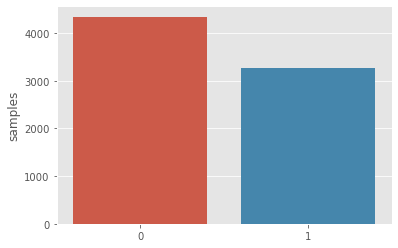

In [8]:
x = train_df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [9]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

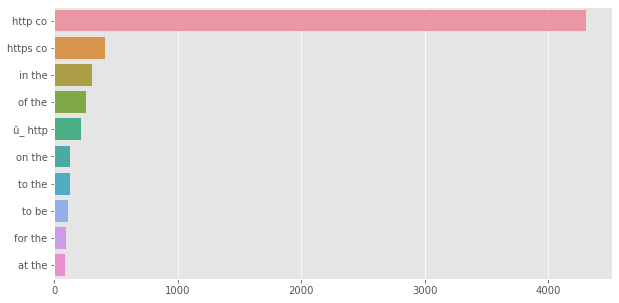

In [10]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_df['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)


In [11]:
df=pd.concat([train_df,test_df])
df.shape

(10876, 5)

### Data Preprocessing

In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def check_pos_tag(x, flag):
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' : ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }
    cnt = 0
    wiki = textblob.TextBlob(x)
    for tup in wiki.tags:
        ppo = list(tup)[1]
        if ppo in pos_family[flag]:
            cnt += 1
    return cnt

def preprocess(df):
    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x: remove_emoji(x))
    df['text']=df['text'].apply(lambda x : correct_spellings(x))
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['noun_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
    df['verb_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
    df['adj_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
    df['adv_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
    df['pron_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'pron'))
    df.to_csv('temp1.csv', index = False)
    return df
    
    

In [13]:
data_path = os.path.join(os.getcwd(), 'temp1.csv')
if not os.path.exists(data_path):
    df = preprocess(df)
else:
    df = pd.read_csv(data_path, index_col = False)

train_df = df[:len(train_df)]
test_df = df[len(train_df):]

### Vectorization

In [14]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [' '.join(self.tokenize(doc)) for doc in X]

    def tokenize(self, sentence):
        for token, tag in pos_tag(wordpunct_tokenize(sentence)):
            # Apply preprocessing to the token
            token = token.lower() if self.lower else token
            token = token.strip() if self.strip else token
            token = token.strip('_') if self.strip else token
            token = token.strip('*') if self.strip else token

            # If stopword, ignore token and continue
            if token in self.stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in self.punct for char in token):
                continue

            # Lemmatize the token and yield
            lemma = self.lemmatize(token, tag)
            yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [32]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = self.word2vec.vector_size

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [39]:
#word2vec using pretrained vec
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-200')

tweet2vec = MeanEmbeddingVectorizer(glove_vectors)
train_word2vec = tweet2vec.transform(train_x.text)
valid_word2vec = tweet2vec.transform(valid_x.text)


In [33]:
#word2vec trained on current dataset
from gensim.models import Word2Vec
word2vec = Word2Vec(vector_size = 300, min_count=1)
train_text = [[word for word in tweet.lower().split()] for tweet in train_df.text]
word2vec.build_vocab(train_text)
word2vec.train(train_text, total_examples = len(train_df), epochs = word2vec.epochs)

tweet2vec = MeanEmbeddingVectorizer(word2vec.wv)
train_word2vec = tweet2vec.transform(train_x.text)
valid_word2vec = tweet2vec.transform(valid_x.text)

### Model

In [35]:
def build_and_evaluate(X, y, vectorizer, stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB()):
    
    def build_vectorizer(vectorizer, corpus, stop_words = None, preprocessor = None):
        if stop_words:    
            vectorizer.set_params(stop_words = stop_words)

        if preprocessor:
            corpus = preprocessor.fit(corpus)
            corpus = preprocessor.transform(corpus)
            vectorizer.set_params(tokenizer = None, preprocessor=None, lowercase=False)

        vectorizer.fit(corpus)
    
        return vectorizer

    def build(X, y, vectorizer, classifier, stop_words = None, preprocessor = None):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()
        
        if not preprocessor:
            vectorizer = build_vectorizer(vectorizer, X, stop_words = stop_words)
            model = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', classifier),
            ])
        else:
            vectorizer = build_vectorizer(vectorizer, X, stop_words = stop_words, preprocessor = preprocessor)
            model = Pipeline([
                ('preprocessor', preprocessor),
                ('vectorizer', vectorizer),
                ('classifier', classifier),
            ])

        model.fit(X, y)
        return model
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 0)
    classifier_name = type(classifier).__name__
    model = build(X_train, y_train, vectorizer, classifier)

    print("Classification Report for {} + {}:\n".format(classifier_name, type(vectorizer).__name__))

    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_pred, y_valid)
    recall = recall_score(y_pred, y_valid)
    precision = precision_score(y_pred, y_valid)
    print("Accuracy is {}".format(accuracy))
    print("Recall is {}".format(recall))
    print("Precision is {}".format(precision))
    
    fitted_model = build(X, y, vectorizer, classifier)
    return fitted_model
    

In [36]:
#Naive Bayes using count vectors
nb_count = build_and_evaluate(train_df.text, train_df.target, CountVectorizer(), stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB())

Classification Report for MultinomialNB + CountVectorizer:

Accuracy is 0.7951411687458962
Recall is 0.8014842300556586
Precision is 0.6781789638932496


In [37]:
#Naive Bayes using tfidf vectors
nb_tfidf = build_and_evaluate(train_df.text, train_df.target, TfidfVectorizer(), stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB())

Classification Report for MultinomialNB + TfidfVectorizer:

Accuracy is 0.7918581746552856
Recall is 0.8418803418803419
Precision is 0.6185243328100472


In [38]:
#SVM using trained word2vec vectors
svc_trained_word2vec = build_and_evaluate(train_df.text, train_df.target, tweet2vec, stop_words = None, 
                       preprocessor = None, classifier = SVC(kernel = 'rbf'))

Classification Report for SVC + MeanEmbeddingVectorizer:

Accuracy is 0.5896257386736704
Recall is 0.6153846153846154
Precision is 0.05023547880690738


In [40]:
#SVM using pretrained word2vec vectors
svc_pretrained_word2vec = build_and_evaluate(train_df.text, train_df.target, tweet2vec, stop_words = None, 
                       preprocessor = None, classifier = SVC(kernel = 'rbf'))

Classification Report for SVC + MeanEmbeddingVectorizer:

Accuracy is 0.6428102429415627
Recall is 0.6388059701492538
Precision is 0.3359497645211931


In [103]:
#Logistic Regression using content features
train_content = train_x[['upper_case_word_count', 'word_count', 'noun_count', 
                          'verb_count', 'adj_count', 'adv_count', 'pron_count']]
valid_content = valid_x[['upper_case_word_count', 'word_count', 'noun_count', 
                          'verb_count', 'adj_count', 'adv_count', 'pron_count']]
lr_content = LogisticRegression()
lr_content.fit(train_content, train_y)
y_valid_pred = lr_content.predict(valid_content)
accuracy = accuracy_score(y_valid_pred, valid_y)
print ("LR, Content Features: ", accuracy)

LR, Content Features:  0.625


In [44]:
##NN config
def get_corpus_mapping(corpus, preprocessor = None, max_tokens = 20000, max_length = 200):
    if preprocessor:
        corpus = NLTKPreprocessor().transform(corpus)
    vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_tokens, output_sequence_length = max_length)
    text_ds = tf.data.Dataset.from_tensor_slices(corpus).batch(128)
    vectorizer.adapt(text_ds)
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    return voc, word_index, vectorizer

def vectorization(vectorizer, data):
    return vectorizer(np.array([[s] for s in data])).numpy()
    
def load_wordvectors(file_name):
    path_to_glove_file = os.path.join(
        os.getcwd(), file_name
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    return embeddings_index

def create_embedding_matrix(voc, embeddings_index, word_index):
    vocab_size = len(voc)
    num_tokens = vocab_size + 2
    embedding_dim = len(list(embeddings_index.values())[0])
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return vocab_size, embedding_dim, embedding_matrix

def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    learning_rate = 0.2
    if epoch > 10:
        learning_rate = 0.02
    if epoch > 20:
        learning_rate = 0.01
    if epoch > 50:
        learning_rate = 0.005

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
def build_model(train_x, valid_x, train_y, valid_y, vectorizer, embedding_matrix, 
       model, loss, optimizer, metric, num_epochs, call_backs):
    
    x_train = vectorization(vectorizer, train_x)
    x_valid = vectorization(vectorizer, valid_x)

    model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
    history = model.fit(x_train, train_y, epochs = num_epochs, 
                        validation_data = (x_valid, valid_y), callbacks = call_backs, num_epochs = num_epochs)
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")
    return model, history.history['val_accuracy']

def predict(model, test_x, threshold = 0.5):
    x_test = vectorizerization(test_x.text)
    y_pred = tf.greater(model.predict(x_test), thresold)
    return y_pred

#### GRU

In [48]:
voc, word_index, vectorizer = get_corpus_mapping(train_df.text, preprocessor = None)
embeddings_index = load_wordvectors("glove.6B.100d.txt")
vocab_size, embedding_dim, embedding_matrix = create_embedding_matrix(voc, embeddings_index, word_index)
num_tokens = vocab_size + 2

x_train, x_valid, y_train, y_valid = train_test_split(train_df.text, train_df.target, test_size=0.2, random_state = 0)

Found 400000 word vectors.
100
Converted 12362 words (5426 misses)


In [49]:
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [stop_callback]
num_epochs = 10
loss = 'binary_crossentropy'
optimizer = 'adam'
metric = 'accuracy'

Epoch 1/10
191/191 [==============================] - 22s 100ms/step - loss: 0.5502 - accuracy: 0.7268 - val_loss: 0.4592 - val_accuracy: 0.7905
Epoch 2/10
191/191 [==============================] - 18s 93ms/step - loss: 0.4420 - accuracy: 0.8069 - val_loss: 0.4438 - val_accuracy: 0.7958
Epoch 3/10
191/191 [==============================] - 18s 94ms/step - loss: 0.4215 - accuracy: 0.8171 - val_loss: 0.4380 - val_accuracy: 0.7971
Epoch 4/10
191/191 [==============================] - 18s 93ms/step - loss: 0.4039 - accuracy: 0.8194 - val_loss: 0.4358 - val_accuracy: 0.7991
Epoch 5/10
191/191 [==============================] - 17s 91ms/step - loss: 0.3882 - accuracy: 0.8309 - val_loss: 0.4370 - val_accuracy: 0.8004
Epoch 6/10
191/191 [==============================] - 17s 92ms/step - loss: 0.3791 - accuracy: 0.8381 - val_loss: 0.4462 - val_accuracy: 0.8011
Epoch 7/10
191/191 [==============================] - 18s 93ms/step - loss: 0.3653 - accuracy: 0.8456 - val_loss: 0.4468 - val_accuracy

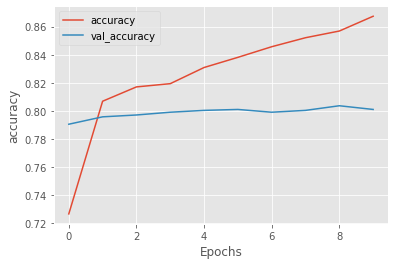

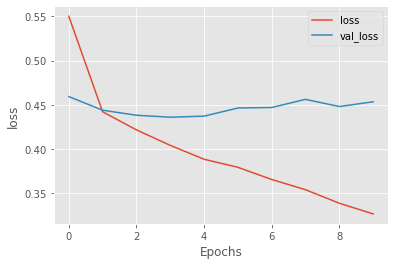

Validation Accuracy is [0.7905449867248535, 0.7957977652549744, 0.7971109747886658, 0.7990807890892029, 0.8003939390182495, 0.8010505437850952, 0.7990807890892029, 0.8003939390182495, 0.803676962852478, 0.8010505437850952]


In [50]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(
    input_dim = num_tokens,
    output_dim=embedding_dim, 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False),
tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
tf.keras.layers.Dense(6, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model,val_acc = build_model(x_train, x_valid, y_train, y_valid, vectorizer, embedding_matrix, 
   model, loss, optimizer, metric, num_epochs, callbacks)
print("Validation Accuracy is {}".format(val_acc))

#### LSTM

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = num_tokens,
        output_dim=embedding_dim, 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model,val_acc = build_model(x_train, x_valid, y_train, y_valid, vectorizer, embedding_matrix, 
   model, loss, optimizer, metric, num_epochs, callbacks)
print("Validation Accuracy is {}".format(val_acc))

Epoch 1/10
191/191 [==============================] - 19s 86ms/step - loss: 0.5012 - accuracy: 0.7647 - val_loss: 0.4537 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 15s 79ms/step - loss: 0.4290 - accuracy: 0.8059 - val_loss: 0.4361 - val_accuracy: 0.8024
Epoch 3/10
191/191 [==============================] - 15s 79ms/step - loss: 0.4145 - accuracy: 0.8161 - val_loss: 0.4347 - val_accuracy: 0.8011
Epoch 4/10
191/191 [==============================] - 15s 77ms/step - loss: 0.3993 - accuracy: 0.8253 - val_loss: 0.4373 - val_accuracy: 0.8030
Epoch 5/10
191/191 [==============================] - 15s 77ms/step - loss: 0.3904 - accuracy: 0.8296 - val_loss: 0.4582 - val_accuracy: 0.8017
Epoch 6/10
191/191 [==============================] - 15s 77ms/step - loss: 0.3756 - accuracy: 0.8412 - val_loss: 0.4404 - val_accuracy: 0.8056
Epoch 7/10
191/191 [==============================] - 18s 93ms/step - loss: 0.3625 - accuracy: 0.8447 - val_loss: 0.4494 - val_accuracy:

INFO:tensorflow:Assets written to: LSTM/assets


INFO:tensorflow:Assets written to: LSTM/assets


#### CNN

Epoch 1/10
191/191 [==============================] - 7s 35ms/step - loss: 0.5124 - accuracy: 0.7473 - val_loss: 0.4643 - val_accuracy: 0.7879
Epoch 2/10
191/191 [==============================] - 7s 37ms/step - loss: 0.3983 - accuracy: 0.8315 - val_loss: 0.4292 - val_accuracy: 0.8122
Epoch 3/10
191/191 [==============================] - 7s 37ms/step - loss: 0.3282 - accuracy: 0.8690 - val_loss: 0.4360 - val_accuracy: 0.8109
Epoch 4/10
191/191 [==============================] - 7s 36ms/step - loss: 0.2683 - accuracy: 0.8977 - val_loss: 0.4799 - val_accuracy: 0.8037
Epoch 5/10
191/191 [==============================] - 7s 34ms/step - loss: 0.1925 - accuracy: 0.9343 - val_loss: 0.6525 - val_accuracy: 0.7577
Epoch 6/10
191/191 [==============================] - 6s 34ms/step - loss: 0.1363 - accuracy: 0.9540 - val_loss: 0.6066 - val_accuracy: 0.7912
Epoch 7/10
191/191 [==============================] - 7s 34ms/step - loss: 0.1155 - accuracy: 0.9581 - val_loss: 0.8181 - val_accuracy: 0.8063

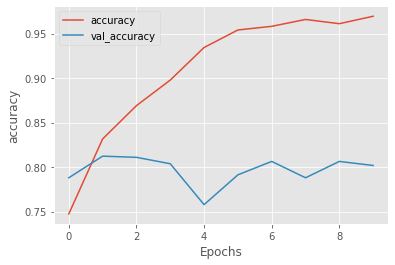

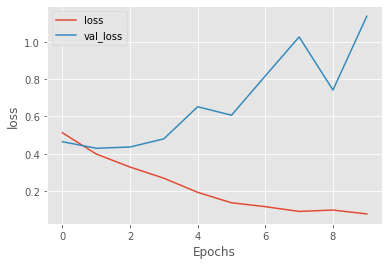

Validation Accuracy is [0.7879185676574707, 0.8122127652168274, 0.810899555683136, 0.803676962852478, 0.7577150464057922, 0.7912015914916992, 0.8063033223152161, 0.7879185676574707, 0.8063033223152161, 0.8017071485519409]


In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = num_tokens,
        output_dim=embedding_dim, 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model,val_acc = build_model(x_train, x_valid, y_train, y_valid, vectorizer, embedding_matrix, 
   model, loss, optimizer, metric, num_epochs, callbacks)
print("Validation Accuracy is {}".format(val_acc))

### Submission

In [22]:
sample_sub=pd.read_csv('sample_submission.csv')

In [23]:
#count vectorizer public score: 0.791
y_pre = nb_count.predict(test_df.text)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [38]:
#GRU with glove vectors public score: 0.810
x_test = vectorizer(np.array([[s] for s in test_df.text])).numpy()
y_pred = tf.greater(model.predict(x_test), .5)
y_pred = np.round(y_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission - GRU.csv',index=False)